In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.preprocessing import RobustScaler

### Global Variables

In [2]:
# baseline for one month prior to start of livetickers
bl_start, bl_end = '2020-02-06', '2020-03-06'
start, end = '2020-03-06', '2021-01-27'

start_lockdown1, start_lockdown2, start_lockdown3 = '2020-03-16', '2020-11-17', '2020-12-26'
end_lockdown1, end_lockdown2, end_lockdown3 = '2020-04-20', '2020-12-06', '2021-02-07'
input_postings = r'../data/preprocessing/combined_postings_final.pickle'
input_summer_gap = r'../data/preprocessing/year_20_final.pickle'
input_survey = r'../data/survey_data_covid_variables.csv'
input_stringency_raw = r'../data/OxCGRT_latest.csv'

### Load datasets

Load and analyize survey dataset:

In [3]:
survey = pd.read_csv(input_survey)
survey_sub = survey[['welle', 'co05_01', 'co06_01', 'co06_02', 'co06_03', 'co06_04', 'co06_05', 'co06_06', 'co08_01', 'co19_01']]
survey_sub.head()

e:\users\moritz\dokumente\uni\ipds_standardforum\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (27,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,welle,co05_01,co06_01,co06_02,co06_03,co06_04,co06_05,co06_06,co08_01,co19_01
0,1,3,2,4,4,4,4,4,3,NaN
1,1,3,1,1,-1,-1,-1,1,1,NaN
2,1,1,1,2,-1,3,4,2,3,NaN
3,1,2,2,2,1,2,1,2,1,NaN
4,1,3,4,3,4,3,4,3,5,NaN


In [4]:
survey_wave_map = {
    1: pd.to_datetime('5.5.2020'),
    2: pd.to_datetime('5.28.2020'),
    3: pd.to_datetime('6.17.2020'),
    4: pd.to_datetime('7.8.2020'),
    5: pd.to_datetime('7.30.2020'),
    6: pd.to_datetime('8.22.2020'),
    7: pd.to_datetime('9.14.2020'),
    8: pd.to_datetime('9.29.2020'),
    9: pd.to_datetime('10.21.2020'),
    10: pd.to_datetime('11.11.2020'),
    11: pd.to_datetime('11.28.2020'),
    12: pd.to_datetime('12.22.2020'),
}

In [5]:
survey_sub['wave_end'] = pd.to_datetime(survey_sub['welle'].map(survey_wave_map))

<ipython-input-5-6168f1e47519>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_sub['wave_end'] = pd.to_datetime(survey_sub['welle'].map(survey_wave_map))


In [6]:
survey_sub = survey_sub.set_index('wave_end')

Load and analyze postings dataset:

In [7]:
cols_to_drop = ['rid', 'ppid', 'o', 'hl', 'tx', 'cn', '13', '16', '17', '19', '31', '200', 'pid_liwc']
postings = pd.read_pickle(input_postings).drop(cols_to_drop, axis=1)
postings.index = pd.to_datetime(postings.cd, utc=True)
postings['anger'] = postings['18']/postings['number_tokens']
postings.loc[postings['18'] > 0, 'anger_yes_no'] = 1
postings.loc[postings['18'] == 0, 'anger_yes_no'] = 0
postings.head()

,oid,pid,cd,vp,vn,allText,18,number_tokens,anger,anger_yes_no
cd,,,,,,,,,,
2020-12-31 19:04:57.643000+00:00,2000122865130,1064710786,2020-12-31 20:04:57.643000+01:00,4,0,Herr Bundespräsidentnach Artikel 70 B-VG könne...,0,28,0.0,0.0
2021-01-01 05:00:14.350000+00:00,2000122865130,1064724063,2021-01-01 06:00:14.350000+01:00,2,0,Der Flash wird noch eine weitere Amtszeit dafü...,0,9,0.0,0.0
2020-12-31 19:57:02.017000+00:00,2000122865130,1064712838,2020-12-31 20:57:02.017000+01:00,2,0,Das ist wahrscheinlich sogar unserem HBP zu pe...,0,8,0.0,0.0
2020-12-31 18:09:04.760000+00:00,2000122865130,1064708391,2020-12-31 19:09:04.760000+01:00,3,0,Ausnahmegesetze für unseren Ausnahmenkanzler ...,0,4,0.0,0.0
2020-12-31 17:43:57.973000+00:00,2000122865130,1064707195,2020-12-31 18:43:57.973000+01:00,3,0,Anschober will...Anschober kann aber nicht.,0,5,0.0,0.0


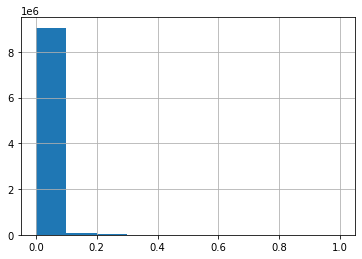

In [8]:
postings['anger'].hist()

plt.show()

Load and analyze dataset of articles to fill gap in the summer

In [9]:
postings_summer_gap = pd.read_pickle(input_summer_gap).sort_index()
postings_summer_gap.index = pd.to_datetime(postings_summer_gap.index, utc=True)
postings_summer_gap['anger2'] = postings_summer_gap['18'] / postings_summer_gap['number_tokens']
postings_summer_gap.loc[postings_summer_gap['18'] > 0, 'anger_yes_no'] = 1
postings_summer_gap.loc[postings_summer_gap['18'] == 0, 'anger_yes_no'] = 0
postings_summer_gap.tail()

,postid,parentid,communityidentityid,communityname,timestamp,followers,ratings_pos,ratings_neg,fullText,13,16,17,18,19,31,200,number_tokens,anger2,anger_yes_no
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-11 21:13:29+00:00,1065338274,1.064871e+09,748531.0,ThomasSV,1610399609,0.0,0,0,Sehe ich nicht... Wenn man das in einen TV Spl...,1,0,0,0,0,1,0,51,0.000000,0.0
2021-01-11 21:18:30+00:00,1065338499,1.064888e+09,748531.0,ThomasSV,1610399910,0.0,0,0,"Es steht Ihnen frei, Politiker zu werden und a...",2,1,0,0,0,2,0,24,0.000000,0.0
2021-01-11 21:22:40+00:00,1065338708,1.064853e+09,748531.0,ThomasSV,1610400160,0.0,0,0,Die Lösung ist schon lange bekannt ;)https://w...,0,0,0,0,0,0,0,7,0.000000,0.0
2021-01-11 21:35:02+00:00,1065339290,1.063851e+09,567219.0,lupos,1610400902,1.0,0,0,"Konsum von Alkohol in Liter 2016RUS: 20,1 AUT:...",0,0,0,0,0,0,0,10,0.000000,0.0
2021-01-11 22:50:27+00:00,1065342095,1.065338e+09,209091.0,StefVienna,1610405427,8.0,0,0,"Sie bestreiten also generell, daß hier ordentl...",0,1,0,1,0,2,0,19,0.052632,1.0


Create dataframe containing liveticker (anger) and articles (anger2) counts as well as the sum

In [10]:
combined = pd.concat([
    postings[
        ['pid', 'anger', '18', 'number_tokens', 'anger_yes_no']
    ].resample('1d').agg(
        {'pid':'size','number_tokens': 'sum', '18': 'sum', 'anger': 'sum', 'anger_yes_no': 'sum'}
    ).rename(columns={'anger': 'anger_livetickers', '18': '18_livetickers', 'number_tokens': 'number_tokens_livetickers', 'anger_yes_no': 'anger_yes_no_livetickers'}), 
    postings_summer_gap[
        ['postid', 'anger2', '18', 'number_tokens', 'anger_yes_no']
    ].resample('1d').agg(
        {'postid':'size','number_tokens': 'sum', '18': 'sum', 'anger2':'sum', 'anger_yes_no': 'sum'}
    ).rename(columns={'anger2': 'anger_articles', '18': '18_articles', 'number_tokens': 'number_tokens_articles', 'anger_yes_no': 'anger_yes_no_articles'})
    ], axis=1).fillna(0)
combined['anger_total'] = (combined['anger_livetickers'] + combined['anger_articles'])
combined['number_anger_tokens'] = (combined['18_livetickers'] + combined['18_articles'])
combined['number_tokens_total'] = combined['number_tokens_livetickers'] + combined['number_tokens_articles']
combined['postings_total'] = combined['pid'] + combined['postid']
combined['anger_yes_no_total'] = combined['anger_yes_no_livetickers'] + combined['anger_yes_no_articles']
combined['anger_yes_no_rel'] = combined['anger_yes_no_total'] / combined['postings_total']
combined['anger_rel'] = combined['number_anger_tokens'] / combined['number_tokens_total']
combined.index = pd.to_datetime(combined.index, utc=True)
combined.head()

,pid,number_tokens_livetickers,18_livetickers,anger_livetickers,anger_yes_no_livetickers,postid,number_tokens_articles,18_articles,anger_articles,anger_yes_no_articles,anger_total,number_anger_tokens,number_tokens_total,postings_total,anger_yes_no_total,anger_yes_no_rel,anger_rel
2020-01-20 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,275.0,6610.0,29.0,0.809049,24.0,0.809049,29.0,6610.0,275.0,24.0,0.087273,0.004387
2020-01-21 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,338.0,8101.0,11.0,0.278864,11.0,0.278864,11.0,8101.0,338.0,11.0,0.032544,0.001358
2020-01-22 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,61.0,1634.0,3.0,0.074917,3.0,0.074917,3.0,1634.0,61.0,3.0,0.049180,0.001836
2020-01-23 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,325.0,6794.0,16.0,0.944649,14.0,0.944649,16.0,6794.0,325.0,14.0,0.043077,0.002355
2020-01-24 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,244.0,7173.0,30.0,1.288482,27.0,1.288482,30.0,7173.0,244.0,27.0,0.110656,0.004182


In [11]:
baseline = combined.loc[bl_start:bl_end].mean()
print('Baseline one month prior liveticker start:', bl_start, 'to', bl_end)
baseline

Baseline one month prior liveticker start: 2020-02-06 to 2020-03-06


pid                              5.000000
number_tokens_livetickers       88.666667
18_livetickers                   0.133333
anger_livetickers                0.009573
anger_yes_no_livetickers         0.133333
postid                        3224.900000
number_tokens_articles       90122.566667
18_articles                    196.700000
anger_articles                   8.058095
anger_yes_no_articles          176.433333
anger_total                      8.067667
number_anger_tokens            196.833333
number_tokens_total          90211.233333
postings_total                3229.900000
anger_yes_no_total             176.566667
anger_yes_no_rel                 0.058143
anger_rel                        0.002200
dtype: float64

In [12]:
final = combined.drop(['number_tokens_livetickers', 'number_tokens_articles'], axis=1)
final = final.loc[start:end]
final['postings_total_diff'] = (final['postings_total'] - baseline['postings_total'])/baseline['postings_total']
final['anger_total_diff'] = (final['anger_total'] - baseline['anger_total'])/baseline['anger_total']
final['anger_yes_no_total_diff'] = (final['anger_yes_no_total'] - baseline['anger_yes_no_total'])/baseline['anger_yes_no_total']
final['anger_yes_no_rel_diff'] = (final['anger_yes_no_rel'] - baseline['anger_yes_no_rel'])/baseline['anger_yes_no_rel']

final

,pid,18_livetickers,anger_livetickers,anger_yes_no_livetickers,postid,18_articles,anger_articles,anger_yes_no_articles,anger_total,number_anger_tokens,number_tokens_total,postings_total,anger_yes_no_total,anger_yes_no_rel,anger_rel,postings_total_diff,anger_total_diff,anger_yes_no_total_diff,anger_yes_no_rel_diff
2020-03-06 00:00:00+00:00,150.0,4.0,0.287179,4.0,7238.0,455.0,18.957352,407.0,19.244531,459.0,212040.0,7388.0,411.0,0.055631,0.002165,1.287377,1.385390,1.327733,-0.043206
2020-03-07 00:00:00+00:00,44.0,0.0,0.000000,0.0,8916.0,560.0,20.801299,494.0,20.801299,560.0,247180.0,8960.0,494.0,0.055134,0.002266,1.774080,1.578354,1.797810,-0.051751
2020-03-08 00:00:00+00:00,16.0,0.0,0.000000,0.0,12003.0,725.0,31.048261,640.0,31.048261,725.0,328230.0,12019.0,640.0,0.053249,0.002209,2.721168,2.848481,2.624693,-0.084169
2020-03-09 00:00:00+00:00,11991.0,316.0,36.327392,300.0,9602.0,565.0,24.844593,502.0,61.171985,881.0,399258.0,21593.0,802.0,0.037142,0.002207,5.685346,6.582363,3.542194,-0.361200
2020-03-10 00:00:00+00:00,45399.0,1264.0,128.991653,1202.0,7194.0,468.0,19.426240,434.0,148.417893,1732.0,747152.0,52593.0,1636.0,0.031107,0.002318,15.283167,17.396631,8.265622,-0.464994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-23 00:00:00+00:00,34403.0,1406.0,125.033905,1276.0,0.0,0.0,0.000000,0.0,125.033905,1406.0,413664.0,34403.0,1276.0,0.037090,0.003399,9.651413,14.498149,6.226732,-0.362092
2021-01-24 00:00:00+00:00,32635.0,1106.0,124.058009,1022.0,0.0,0.0,0.000000,0.0,124.058009,1106.0,361231.0,32635.0,1022.0,0.031316,0.003062,9.104028,14.377185,4.788182,-0.461395
2021-01-25 00:00:00+00:00,684.0,16.0,2.858739,16.0,0.0,0.0,0.000000,0.0,2.858739,16.0,7517.0,684.0,16.0,0.023392,0.002129,-0.788229,-0.645655,-0.909383,-0.597684
2021-01-26 00:00:00+00:00,5.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,146.0,5.0,0.0,0.000000,0.000000,-0.998452,-1.000000,-1.000000,-1.000000


In [13]:
number_of_total_postings = postings['18'].size + postings_summer_gap['18'].size
number_of_postings_with_no_anger_tokens = postings['18'][postings['18'] == 0].size + postings_summer_gap['18'][postings_summer_gap['18'] == 0].size

print('Number of postings total: ', number_of_total_postings)
print('Number of postings with zero anger tokens: ', number_of_postings_with_no_anger_tokens, '(', number_of_postings_with_no_anger_tokens/number_of_total_postings ,'%)')

Number of postings total:  10580670
Number of postings with zero anger tokens:  10166924 ( 0.9608960491159823 %)


Create baseline difference for selected surey questions

In [14]:
survey_grouped = survey_sub.groupby('welle').resample('1d').mean()
survey_grouped.index = survey_grouped.index.droplevel('welle')
survey_grouped['baseline_diff_05'] = (survey_grouped['co05_01'] - survey_grouped['co05_01'][0])/survey_grouped['co05_01'][0]
survey_grouped['baseline_diff_06_1'] = (survey_grouped['co06_01'] - survey_grouped['co06_01'][0])/survey_grouped['co06_01'][0]
survey_grouped['baseline_diff_06_2'] = (survey_grouped['co06_02'] - survey_grouped['co06_02'][0])/survey_grouped['co06_02'][0]
survey_grouped['baseline_diff_06_3'] = (survey_grouped['co06_03'] - survey_grouped['co06_03'][0])/survey_grouped['co06_03'][0]
survey_grouped['baseline_diff_06_4'] = (survey_grouped['co06_04'] - survey_grouped['co06_04'][0])/survey_grouped['co06_04'][0]
survey_grouped['baseline_diff_06_5'] = (survey_grouped['co06_05'] - survey_grouped['co06_05'][0])/survey_grouped['co06_05'][0]
survey_grouped['baseline_diff_06_6'] = (survey_grouped['co06_06'] - survey_grouped['co06_06'][0])/survey_grouped['co06_06'][0]
survey_grouped['baseline_diff_08'] = (survey_grouped['co08_01'] - survey_grouped['co08_01'][0])/survey_grouped['co08_01'][0]
survey_grouped['baseline_diff_19'] = (survey_grouped['co19_01'] - survey_grouped['co19_01'][9])/survey_grouped['co19_01'][9]
survey_grouped

,welle,co05_01,co06_01,co06_02,co06_03,co06_04,co06_05,co06_06,co08_01,co19_01,baseline_diff_05,baseline_diff_06_1,baseline_diff_06_2,baseline_diff_06_3,baseline_diff_06_4,baseline_diff_06_5,baseline_diff_06_6,baseline_diff_08,baseline_diff_19
wave_end,,,,,,,,,,,,,,,,,,,
2020-05-05,1.0,1.639361,2.182817,1.422577,0.564436,2.892108,2.083916,2.154845,2.535465,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2020-05-28,2.0,1.612935,1.900498,1.254726,0.735323,2.503483,2.010945,1.963184,2.532338,NaN,-0.016119,-0.129337,-0.117991,0.302759,-0.134374,-0.035016,-0.088944,-0.001233,NaN
2020-06-17,3.0,1.617383,1.651349,1.199800,0.615385,2.144855,1.996004,1.879121,2.480519,NaN,-0.013406,-0.243478,-0.156601,0.090265,-0.258377,-0.042186,-0.127955,-0.021671,NaN
2020-07-08,4.0,2.043000,1.475000,1.064000,0.488000,1.916000,1.864000,1.628000,2.410000,NaN,0.246218,-0.324268,-0.252062,-0.135419,-0.337507,-0.105530,-0.244493,-0.049484,NaN
2020-07-30,5.0,2.285000,1.442000,1.057000,0.344000,1.871000,1.811000,1.709000,2.358000,NaN,0.393836,-0.339386,-0.256982,-0.390542,-0.353067,-0.130963,-0.206904,-0.069993,NaN
2020-08-22,6.0,2.093812,1.503992,1.081836,0.394212,1.885230,1.860279,1.838323,2.337325,NaN,0.277213,-0.310986,-0.239524,-0.301583,-0.348147,-0.107316,-0.146888,-0.078147,NaN
2020-09-14,7.0,2.126747,1.421158,1.055888,0.408184,1.867265,1.892216,1.811377,2.393214,NaN,0.297302,-0.348934,-0.257764,-0.276829,-0.354358,-0.091991,-0.159393,-0.056104,NaN
2020-09-29,8.0,2.158000,1.553000,1.109000,0.426000,2.028000,1.897000,1.822000,2.486000,NaN,0.316367,-0.288534,-0.220429,-0.245264,-0.298781,-0.089695,-0.154464,-0.019509,NaN
2020-10-21,9.0,2.120159,1.614697,1.092354,0.390268,2.077458,2.006951,1.811321,2.602781,NaN,0.293284,-0.260269,-0.232131,-0.308569,-0.281680,-0.036933,-0.159420,0.026550,NaN


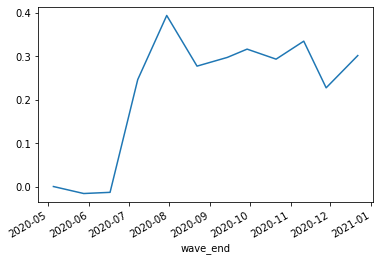

In [15]:
survey_grouped['baseline_diff_05'].plot()

plt.show()

Load and analyze stringency index dataset: 

In [16]:
fields = ['CountryCode', 'Date', 'StringencyIndex', 'ConfirmedCases']
stringency_df = pd.read_csv(input_stringency_raw, usecols=fields).fillna(0.1)
stringency_df = stringency_df[stringency_df['CountryCode'] == 'AUT']
stringency_df.index = pd.to_datetime(stringency_df.Date, format= '%Y%m%d')
stringency_df['StringencyIndex'] = pd.to_numeric(stringency_df['StringencyIndex'])
stringency_df['ConfirmedCases'] = pd.to_numeric(stringency_df['ConfirmedCases'])

stringency_df_final = stringency_df.loc[start:end]
stringency_df_final['StringencyIndex_diff'] = (stringency_df_final['StringencyIndex'] - stringency_df_final['StringencyIndex'][0])/stringency_df_final['StringencyIndex'][0]
stringency_df_final['ConfirmedCases_diff'] = (stringency_df_final['ConfirmedCases'] - stringency_df_final['ConfirmedCases'][0])/stringency_df_final['ConfirmedCases'][0]


<ipython-input-16-aa6b393b8e67>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stringency_df_final['StringencyIndex_diff'] = (stringency_df_final['StringencyIndex'] - stringency_df_final['StringencyIndex'][0])/stringency_df_final['StringencyIndex'][0]
<ipython-input-16-aa6b393b8e67>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stringency_df_final['ConfirmedCases_diff'] = (stringency_df_final['ConfirmedCases'] - stringency_df_final['ConfirmedCases'][0])/stringency_df_final['ConfirmedCases'][0]


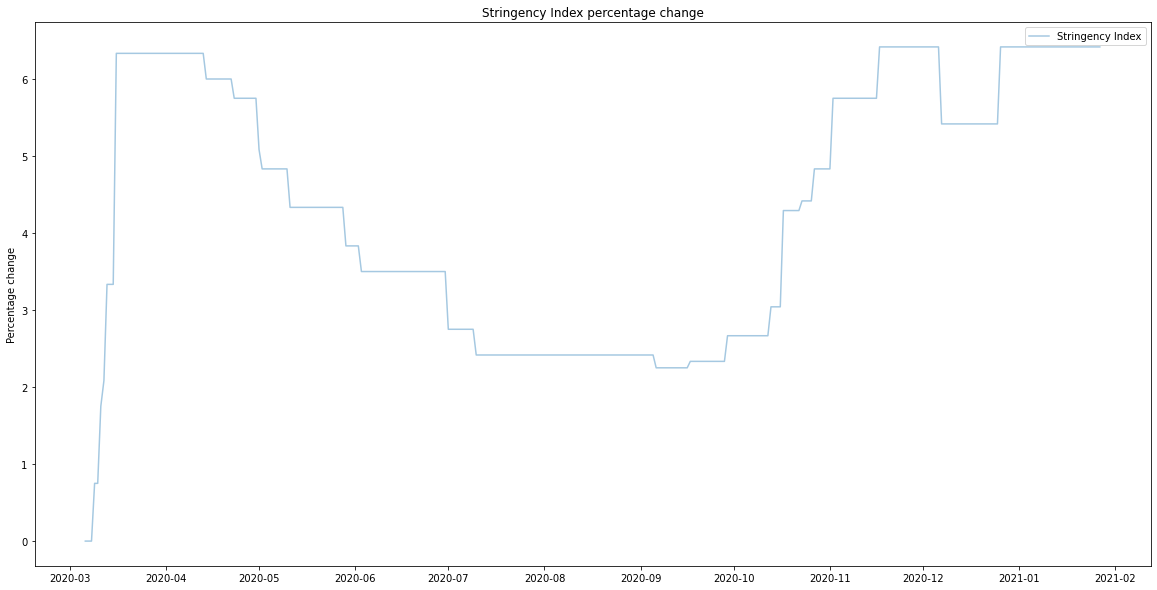

In [17]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot((stringency_df_final['StringencyIndex_diff']), alpha=0.4, label='Stringency Index')

plt.title('Stringency Index percentage change')
ax.set_ylabel('Percentage change')

lines, labels = ax.get_legend_handles_labels()
ax.legend(loc='best')

plt.show()

### Plots

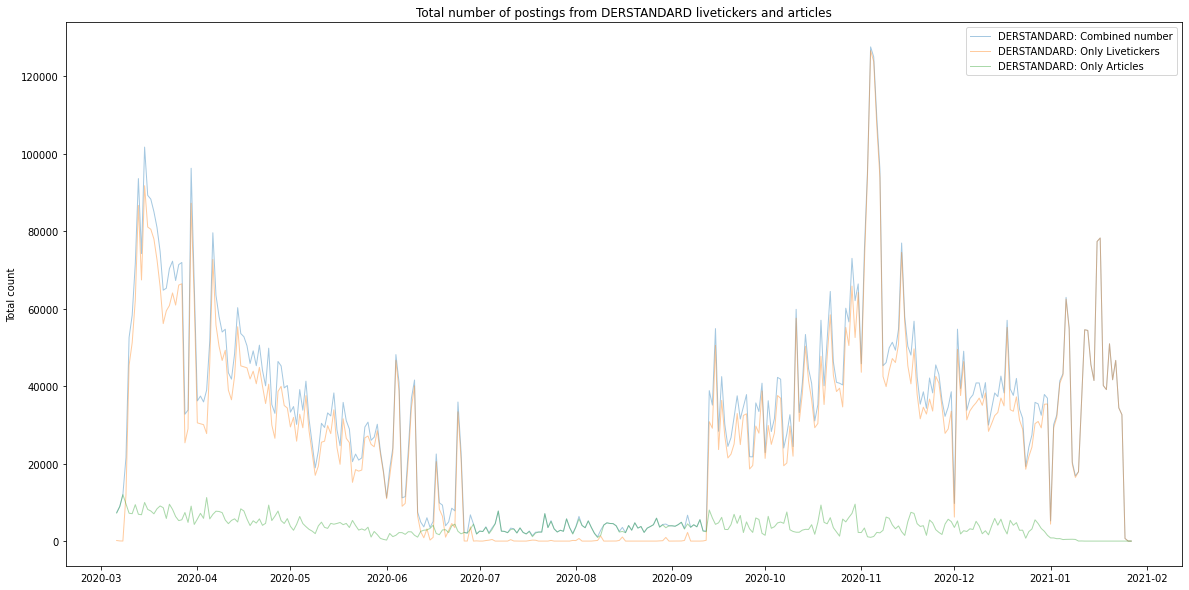

In [18]:
fig, ax = plt.subplots(figsize=(20,10))

plt.title('Total number of postings from DERSTANDARD livetickers and articles')
ax.set_ylabel('Total count')
ax.plot(final['postings_total'], label='DERSTANDARD: Combined number', linestyle='-', linewidth=1, alpha=0.4)
ax.plot(final['pid'], label='DERSTANDARD: Only Livetickers', linestyle='-', linewidth=1, alpha=0.4)
ax.plot(final['postid'], label='DERSTANDARD: Only Articles', linestyle='-', linewidth=1, alpha=0.4)
plt.legend(loc='upper right')

plt.show()

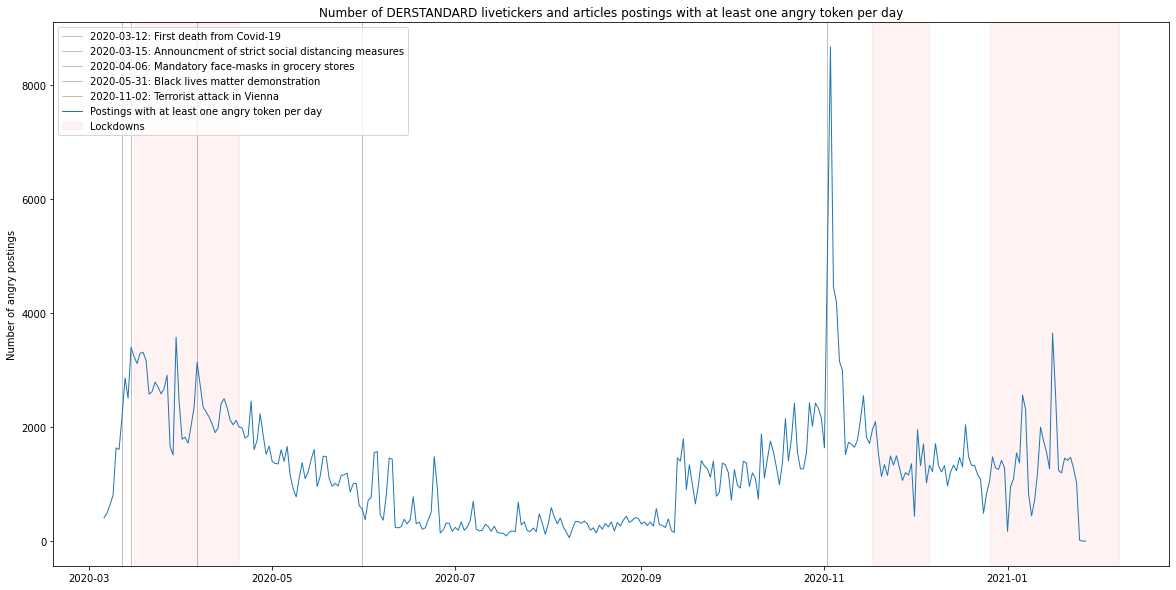

In [19]:
fig, ax = plt.subplots(figsize=(20,10))

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')

ax.plot(final['anger_yes_no_total'], label='Postings with at least one angry token per day', linestyle='-', linewidth=1, alpha=1)


plt.title('Number of DERSTANDARD livetickers and articles postings with at least one angry token per day')
ax.set_ylabel('Number of angry postings')

plt.legend(loc='upper left')

plt.show()

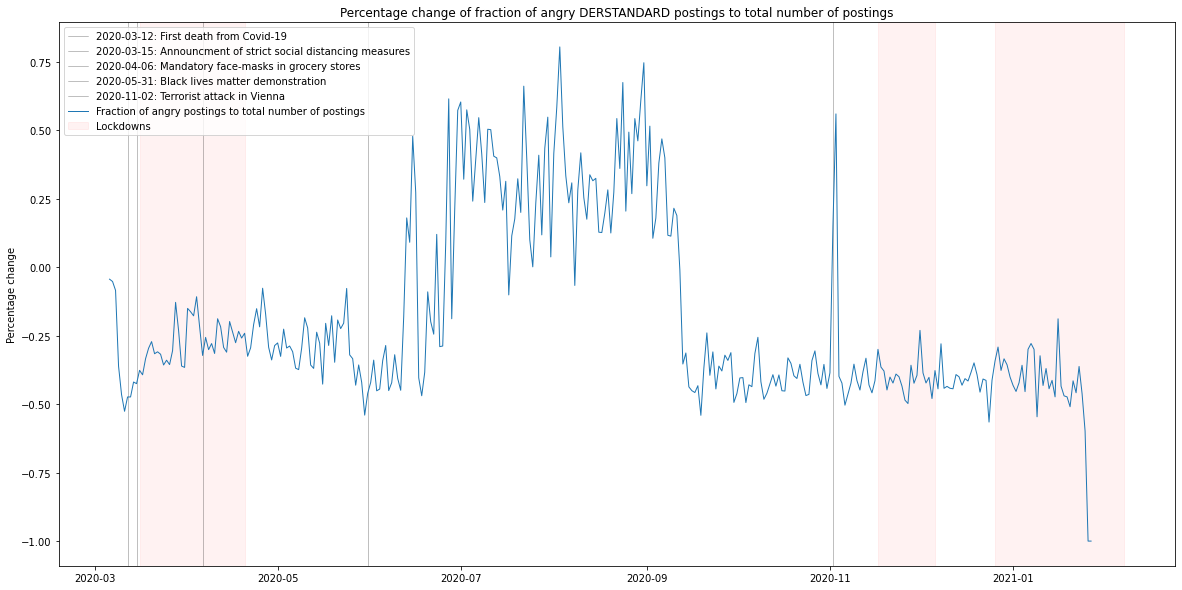

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')

ax.plot(final['anger_yes_no_rel_diff'], label='Fraction of angry postings to total number of postings', linestyle='-', linewidth=1, alpha=1)

plt.title('Percentage change of fraction of angry DERSTANDARD postings to total number of postings')
ax.set_ylabel('Percentage change')

plt.legend(loc='upper left')

plt.show()

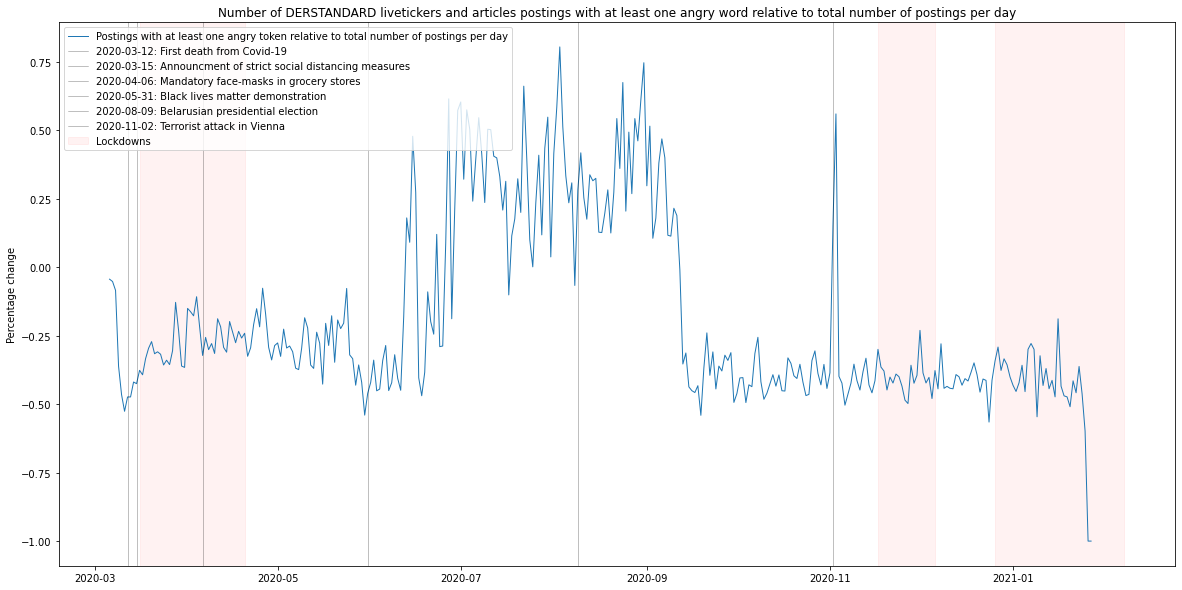

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(final['anger_yes_no_rel_diff'], label='Postings with at least one angry token relative to total number of postings per day', linestyle='-', linewidth=1, alpha=1)
ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
ax.axvline(pd.to_datetime('2020-08-09'), linewidth=0.5, color='black', alpha=0.5, label='2020-08-09: Belarusian presidential election')
ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')

plt.title('Number of DERSTANDARD livetickers and articles postings with at least one angry word relative to total number of postings per day')
ax.set_ylabel('Percentage change')

lines, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left')

plt.show()

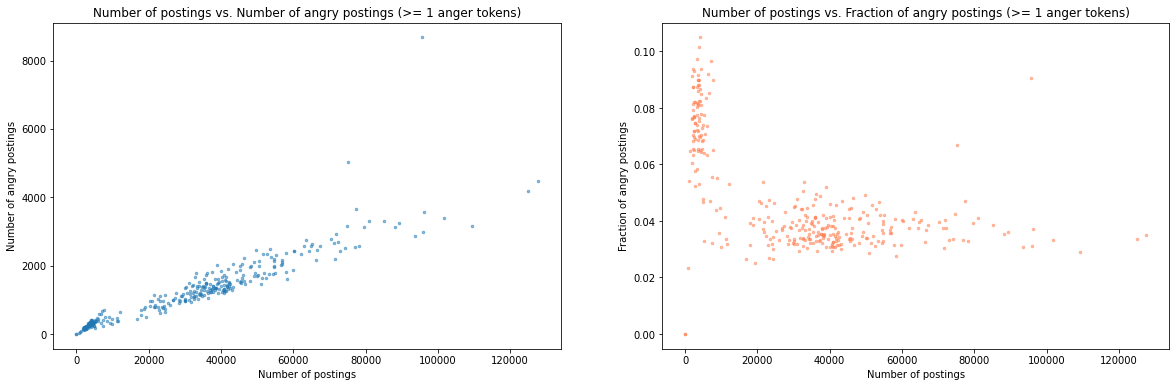

	Number of postings vs. Number of angry postings: 		Number of postings vs. Fraction of angry postings:
	Pearson-R: 	0.92344						Pearson-R: 	-0.58338
	p-value: 	1.1848160624936768e-137				p-value: 	2.6693708931056157e-31


In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
area = np.pi*2
ax1.scatter(final['postings_total'], final['anger_yes_no_total'], s=area, alpha=0.5)
ax1.set_title('Number of postings vs. Number of angry postings (>= 1 anger tokens)')
ax1.set_xlabel('Number of postings')
ax1.set_ylabel('Number of angry postings')

ax2.scatter(final['postings_total'], final['anger_yes_no_rel'], s=area, alpha=0.5, color='coral')
ax2.set_title('Number of postings vs. Fraction of angry postings (>= 1 anger tokens)')
ax2.set_xlabel('Number of postings')
ax2.set_ylabel('Fraction of angry postings')

plt.show()

print('\tNumber of postings vs. Number of angry postings: \t\tNumber of postings vs. Fraction of angry postings:')
r1, p1 = sp.stats.pearsonr(final['postings_total'], final['anger_yes_no_total'])
r2, p2 = sp.stats.pearsonr(final['postings_total'], final['anger_yes_no_rel'])
print('\tPearson-R: \t{:.5f}\t\t\t\t\t\tPearson-R: \t{:.5f}'.format(r1,r2))
print('\tp-value: \t{}\t\t\t\tp-value: \t{}'.format(p1,p2))

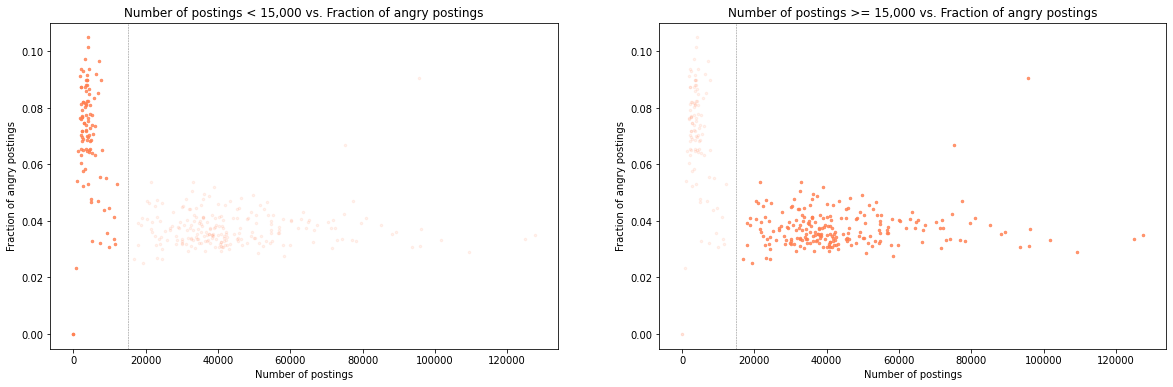

	T-Test of fraction of angry postings between days with postings < 15,000 and >= 15,000:
	t-score:	21.86419
	p-value:	7.095479992101005e-66


In [45]:
small_stub = final[final['postings_total'] < 15000]
big_stub = final[final['postings_total'] >= 15000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
area = np.pi*2
ax1.scatter(small_stub['postings_total'], small_stub['anger_yes_no_rel'], s=area, alpha=0.8, color='coral')
ax1.scatter(big_stub['postings_total'], big_stub['anger_yes_no_rel'], s=area, alpha=0.1, color='coral')
ax1.set_title('Number of postings < 15,000 vs. Fraction of angry postings')
ax1.set_xlabel('Number of postings')
ax1.set_ylabel('Fraction of angry postings')
ax1.axvline(15000, linewidth=0.5, color='black', alpha=0.5, linestyle='--')

ax2.scatter(small_stub['postings_total'], small_stub['anger_yes_no_rel'], s=area, alpha=0.1, color='coral')
ax2.scatter(big_stub['postings_total'], big_stub['anger_yes_no_rel'], s=area, alpha=0.8, color='coral')
ax2.set_title('Number of postings >= 15,000 vs. Fraction of angry postings')
ax2.set_xlabel('Number of postings')
ax2.set_ylabel('Fraction of angry postings')
ax2.axvline(15000, linewidth=0.5, color='black', alpha=0.5, linestyle='--')
plt.show()

#print('\tNumber of postings vs. Fraction of angry postings \t\tNumber of postings vs. Fraction of angry postings')
#print('\twith number of postings < 15,000\t\t\t\twith number of postings >= 15,000:')
#r1, p1 = sp.stats.pearsonr(small_stub['postings_total'], small_stub['anger_yes_no_rel'])
#r2, p2 = sp.stats.pearsonr(big_stub['postings_total'], big_stub['anger_yes_no_rel'])
#print('\tPearson-R: \t{:.5f}\t\t\t\t\t\tPearson-R: \t{:.5f}'.format(r1,r2))
#print('\tp-value: \t{}\t\t\t\tp-value: \t{}'.format(p1,p2))
#print()
print('\tT-Test of fraction of angry postings between days with postings < 15,000 and >= 15,000:')
s, p = sp.stats.ttest_ind(small_stub['anger_yes_no_rel'], big_stub['anger_yes_no_rel'])
print('\tt-score:\t{:.5f}'.format(s))
print('\tp-value:\t{}'.format(p))

<ipython-input-24-d7bcf50923ff>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(lables)


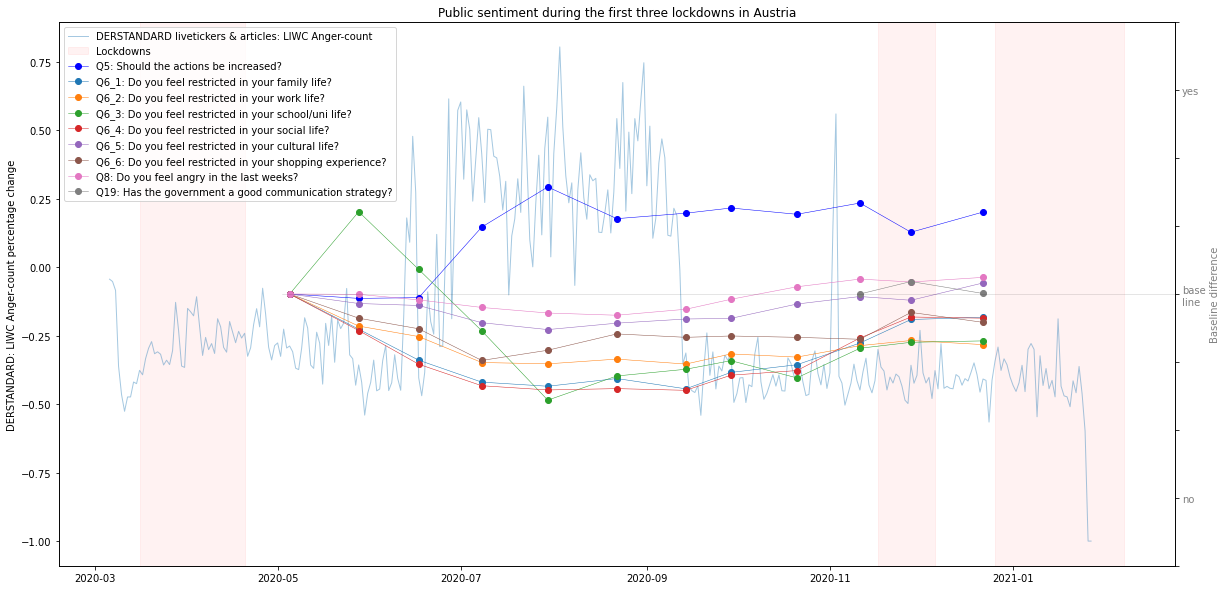

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(final['anger_total'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: LIWC Anger-count')
ax.plot(final['anger_yes_no_rel_diff'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: LIWC Anger-count')

ax.set_ylabel('DERSTANDARD: LIWC Anger-count percentage change')

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

#ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
#ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
#ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
#ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
#ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')

ax2 = ax.twinx()
ax2.set_ylim([-1,1])
lables = [item.get_text() for item in ax2.get_yticklabels()]
lables[1] = 'no'
lables[len(lables)-2] = 'yes'
lables[int(len(lables)/2)] = 'base\nline'
ax2.set_yticklabels(lables)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_05'],label="Q5: Should the actions be increased?", linestyle='-', marker='o', linewidth=0.5, color='blue', alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_1'],label="Q6_1: Do you feel restricted in your family life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_2'],label="Q6_2: Do you feel restricted in your work life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_3'],label="Q6_3: Do you feel restricted in your school/uni life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_4'],label="Q6_4: Do you feel restricted in your social life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_5'],label="Q6_5: Do you feel restricted in your cultural life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_6'],label="Q6_6: Do you feel restricted in your shopping experience?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_08'],label="Q8: Do you feel angry in the last weeks?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_19'],label="Q19: Has the government a good communication strategy?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.axhline(y=0, xmin=0.2, linewidth=0.5, alpha=0.2, linestyle='-', color='black')

ax2.tick_params(axis='y', labelcolor='gray')

ax2.set_ylabel("Baseline difference", color='gray')
ax.set_title("Public sentiment during the first three lockdowns in Austria")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

<ipython-input-25-cb8f8c90b054>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(lables)


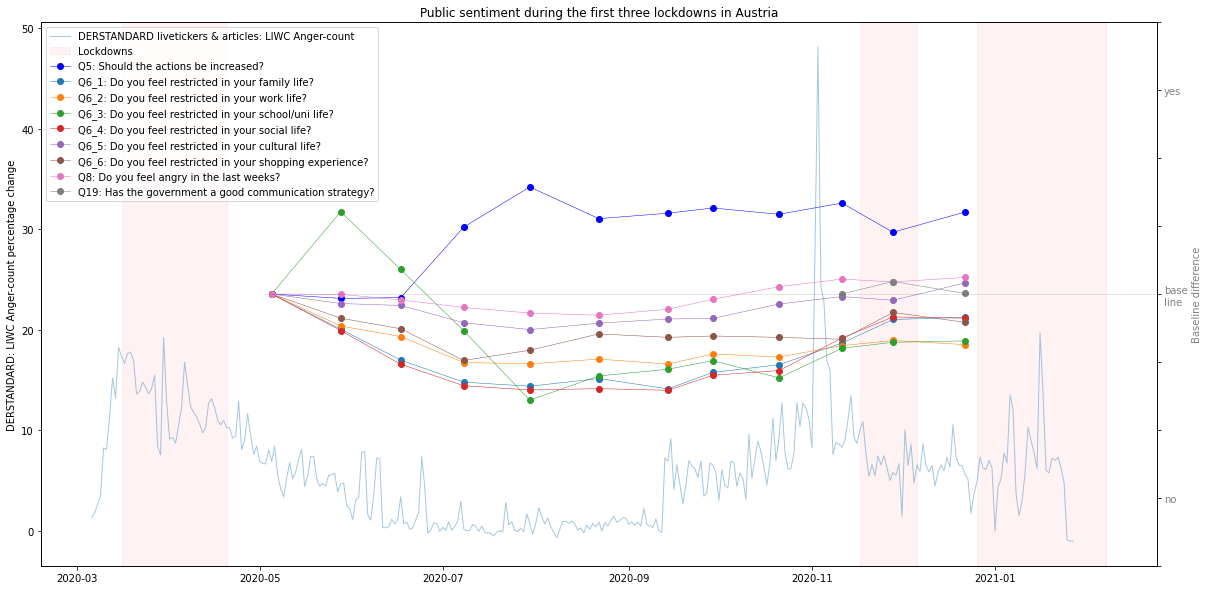

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(final['anger_total'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: LIWC Anger-count')
ax.plot(final['anger_yes_no_total_diff'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: LIWC Anger-count')

ax.set_ylabel('DERSTANDARD: LIWC Anger-count percentage change')

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

#ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
#ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
#ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
#ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
#ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')

ax2 = ax.twinx()
ax2.set_ylim([-1,1])
lables = [item.get_text() for item in ax2.get_yticklabels()]
lables[1] = 'no'
lables[len(lables)-2] = 'yes'
lables[int(len(lables)/2)] = 'base\nline'
ax2.set_yticklabels(lables)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_05'],label="Q5: Should the actions be increased?", linestyle='-', marker='o', linewidth=0.5, color='blue', alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_1'],label="Q6_1: Do you feel restricted in your family life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_2'],label="Q6_2: Do you feel restricted in your work life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_3'],label="Q6_3: Do you feel restricted in your school/uni life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_4'],label="Q6_4: Do you feel restricted in your social life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_5'],label="Q6_5: Do you feel restricted in your cultural life?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_6'],label="Q6_6: Do you feel restricted in your shopping experience?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_08'],label="Q8: Do you feel angry in the last weeks?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_19'],label="Q19: Has the government a good communication strategy?", linestyle='-', marker='o', linewidth=0.5, alpha=1)
ax2.axhline(y=0, xmin=0.2, linewidth=0.5, alpha=0.2, linestyle='-', color='black')

ax2.tick_params(axis='y', labelcolor='gray')

ax2.set_ylabel("Baseline difference", color='gray')
ax.set_title("Public sentiment during the first three lockdowns in Austria")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

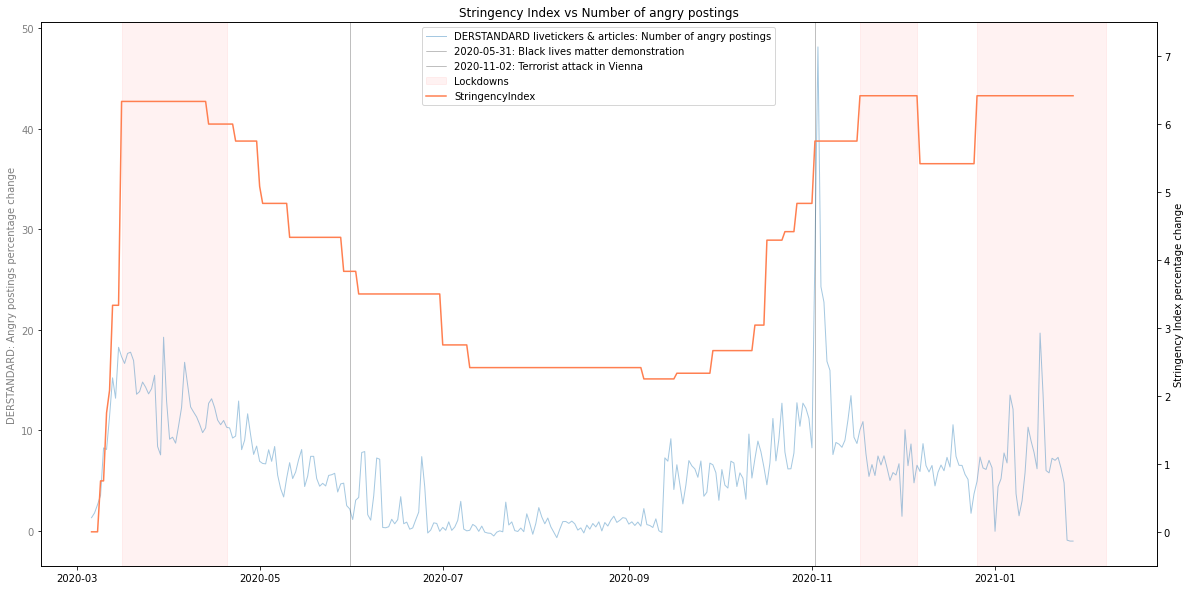

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(final['anger_total'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: LIWC Anger-count')
ax.plot(final['anger_yes_no_total_diff'], linestyle='-', linewidth=1, alpha=0.4, label='DERSTANDARD livetickers & articles: Number of angry postings')

ax.set_ylabel('DERSTANDARD: Angry postings percentage change', color='grey')
ax.tick_params(axis='y', labelcolor='grey')

ax2 = ax.twinx()
ax2.plot(stringency_df_final['StringencyIndex_diff'], alpha=1, color='coral', label='StringencyIndex')
ax2.set_ylim([-0.5,7.5])
ax2.tick_params(axis='y', labelcolor='black')

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

#ax.axvline(pd.to_datetime('2020-03-12'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-12: First death from Covid-19')
#ax.axvline(pd.to_datetime('2020-03-15'), linewidth=0.5, color='black', alpha=0.5, label='2020-03-15: Announcment of strict social distancing measures')
#ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='black', alpha=0.5, label='2020-04-06: Mandatory face-masks in grocery stores')
ax.axvline(pd.to_datetime('2020-05-31'), linewidth=0.5, color='black', alpha=0.5, label='2020-05-31: Black lives matter demonstration')
ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='black', alpha=0.5, label='2020-11-02: Terrorist attack in Vienna')


ax2.set_ylabel("Stringency Index percentage change", color='black')
ax.set_title("Stringency Index vs Number of angry postings")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center')

plt.show()

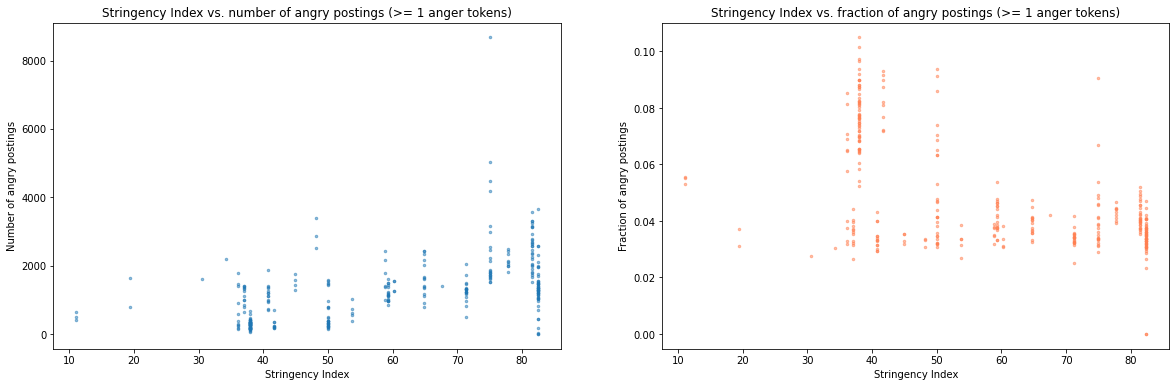

	Stringency Index vs. number of angry postings: 			Stringency Index vs. fraction of angry postings:
	spearman corr.	0.56460						spearman corr.	-0.42044
	p-value: 	5.2183952832592e-29				p-value: 	1.7581958210897822e-15


In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
area = np.pi*2
ax1.scatter(stringency_df_final['StringencyIndex'], final['anger_yes_no_total'], s=area, alpha=0.5)
ax1.set_title('Stringency Index vs. number of angry postings (>= 1 anger tokens)')
ax1.set_xlabel('Stringency Index')
ax1.set_ylabel('Number of angry postings')

ax2.scatter(stringency_df_final['StringencyIndex'], final['anger_yes_no_rel'], s=area, alpha=0.5, color='coral')
ax2.set_title('Stringency Index vs. fraction of angry postings (>= 1 anger tokens)')
ax2.set_xlabel('Stringency Index')
ax2.set_ylabel('Fraction of angry postings')

plt.show()

print('\tStringency Index vs. number of angry postings: \t\t\tStringency Index vs. fraction of angry postings:')
c1, p1 = sp.stats.spearmanr(stringency_df_final['StringencyIndex'], final['anger_yes_no_total'])
c2, p2 = sp.stats.spearmanr(stringency_df_final['StringencyIndex'], final['anger_yes_no_rel'])
print('\tspearman corr.\t{:.5f}\t\t\t\t\t\tspearman corr.\t{:.5f}'.format(c1,c2))
print('\tp-value: \t{}\t\t\t\tp-value: \t{}'.format(p1,p2))

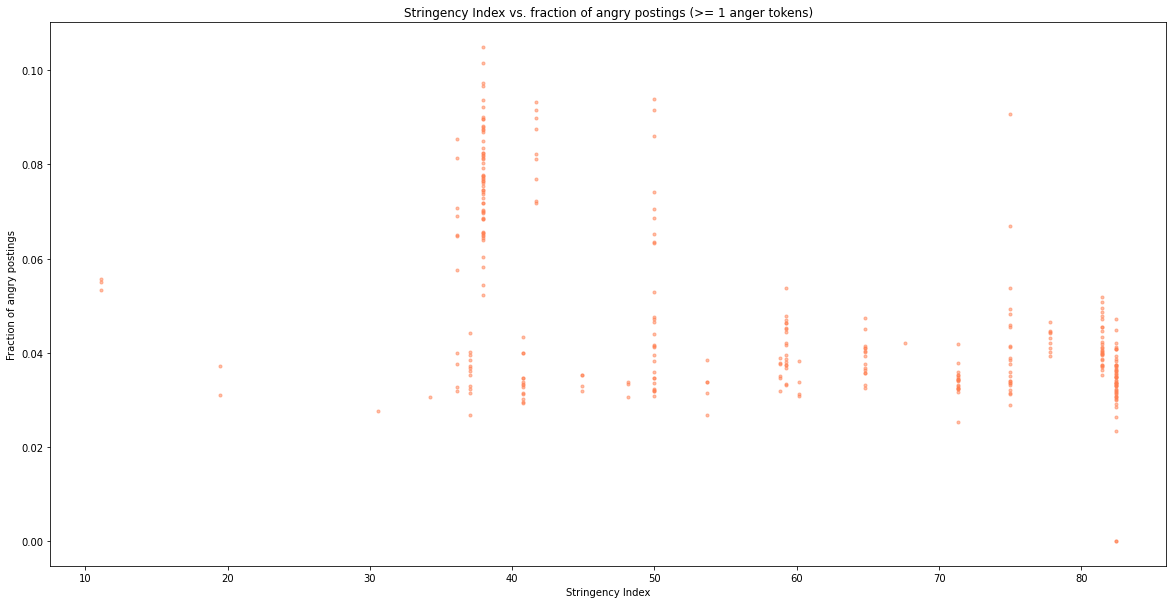

	Stringency Index vs. fraction of angry postings:
	spearman corr.:	-0.42044
	p-value: 	1.7581958210897822e-15


In [51]:
fig, ax2 = plt.subplots(figsize=(20,10))
area = np.pi*3

ax2.scatter(stringency_df_final['StringencyIndex'], final['anger_yes_no_rel'], s=area, alpha=0.5, color='coral')
ax2.set_title('Stringency Index vs. fraction of angry postings (>= 1 anger tokens)')
ax2.set_xlabel('Stringency Index')
ax2.set_ylabel('Fraction of angry postings')

plt.show()

print('\tStringency Index vs. fraction of angry postings:')
c2, p2 = sp.stats.spearmanr(stringency_df_final['StringencyIndex'], final['anger_yes_no_rel'])
print('\tspearman corr.:\t{:.5f}'.format(c2))
print('\tp-value: \t{}'.format(p2))